# Perceptron

This notebook implements **Perceptron** as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 4)** by Anand Avati.

It includes:
- Feature normalization using **Z-score**
- Optimization using **Perceptron learning algorithm** (mistake-driven online updates)
- Early stopping when no misclassification occurs in an epoch
- Visualization of training data and decision boundary


In [41]:
import pickle
import numpy as np
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt

In [38]:
class Perceptron():

    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.x_norm: ndarray = None
        self.theta: ndarray = None
        self.is_norm: bool = False
        self.add_bias: bool = True

    @staticmethod
    def g(x):
        return np.where(x >= 0, 1, 0)

    
    @staticmethod
    def h(x: ndarray, theta:ndarray) -> ndarray:
        return Perceptron.g(np.dot(x, theta))
    
    def normalize(self, x_train: ndarray, add_bias: bool = True):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.x_std[self.x_std == 0] = 1
        x_norm = (x_train - self.x_mean) / self.x_std
        if add_bias:
            x_0 = np.ones((x_train.shape[0], 1))
            self.x_norm = np.hstack([x_0, x_norm])
        self.is_norm = True

    def train(self, x_train: ndarray, y_train: ndarray, add_bias: bool = True, theta: ndarray = None, alpha: float = 0.001, epoch: int = 100):
        if not self.is_norm:
            self.normalize(x_train, add_bias)

        m, n = self.x_norm.shape
        if theta is None:
            theta = np.zeros((n, 1))

        converged = False  # Track if training ever converged

        for ep in range(epoch):
            is_updated = False
            for i in range(m):
                xi = self.x_norm[i].reshape(-1, 1)
                yi = y_train[i]
                dp = (xi.T @ theta).item()
                pred = Perceptron.g(dp)
                error = yi - pred
                x_comp = xi * error
                if not np.allclose(x_comp, 0):
                    theta += alpha * x_comp
                    is_updated = True

            if not is_updated:
                print(f"Model converged at epoch {ep+1}")
                converged = True
                break  # early stop

        if not converged:
            print("Model did not converge in given epochs. More training may be needed.")

        self.theta = theta
        y_probs = Perceptron.h(self.x_norm, theta)
        accuracy = np.mean(y_probs.flatten() == y_train.flatten()) * 100
        print(f"Accuracy: {accuracy:.2f}%")
    # Plotting decision boundary
        colors = ['blue' if label == 0 else 'red' for label in y_train]
        x_1 = self.x_norm[:, 1].flatten()
        x_2 = self.x_norm[:, 2].flatten()
        x_min, x_max = x_1.min() - 0.5, x_1.max() + 0.5
        x_vals = np.linspace(x_min, x_max, 100)
        t0, t1, t2 = theta[0].item(), theta[1].item(), theta[2].item()

        plt.figure(figsize=(6, 6))
        plt.scatter(x_1, x_2, c=colors, edgecolor='k', alpha=0.8, label="Training Data")

        if t2 != 0:
            y_vals = -(t0 + t1 * x_vals) / t2
            plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')
        elif t1 != 0:
            x_boundary = -t0 / t1
            plt.axvline(x_boundary, color='k', linestyle='--', label='Vertical Decision Boundary')
        else:
            print("Warning: No valid decision boundary (theta[1] and theta[2] == 0)")
            plt.title("No valid decision boundary")

        plt.xlabel("Normalized x1")
        plt.ylabel("Normalized x2")
        plt.title("Perceptron Decision Boundary")
        plt.legend()
        plt.grid(True)
        plt.show()
        


In [29]:
data = pd.read_csv("./data/train.csv")
data.head()

,x1,x2,y
0,-1.887934,1.981047,0
1,-2.161668,0.230017,0
2,-2.488704,2.502715,0
3,1.842736,-2.423522,1
4,2.373594,-1.927079,1


In [30]:
x_train = data[["x1","x2"]].values
y_train = data[["y"]].values

Model converged at epoch 2
Accuracy: 100.00%


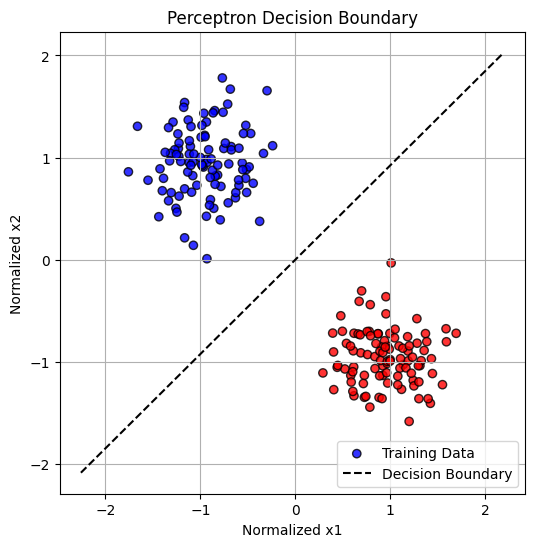

In [39]:
model = Perceptron()
model.train(x_train,y_train)

In [40]:
print(model.theta)

[[ 0.        ]
 [ 0.00141531]
 [-0.00153103]]


## Training Logistic Regression on same dataset for accuracy comparision

In [42]:
class LogisticRegression():
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.x_max: ndarray = None
        self.x_min: ndarray = None
        self.x_norm: ndarray = None
        self.theta: ndarray = None
        self.thetaSGD: ndarray = None
        self.thetaNR: ndarray = None
        self.normtype: str = None
        self.add_bias: bool = None
        self.is_norm: bool = False
    @staticmethod
    def g(z: ndarray) -> ndarray:
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def h(x: ndarray, theta:ndarray) -> ndarray:
        return LogisticRegression.g(np.dot(x, theta))
    @staticmethod
    def l(theta: ndarray, x: ndarray, y: ndarray):
        """log likelihood of `theta`"""
        m = x.shape[0]
        h=LogisticRegression.h
        return (1 / m) * np.sum((y *np.log(h(x,theta))) + ((1 - y) * np.log(1 - h(x, theta))))

    @staticmethod
    def J(theta: ndarray, x: ndarray, y: ndarray):
        return -LogisticRegression.l(theta, x, y)
    
    @staticmethod
    def predict(X: ndarray, theta:ndarray):
        return (LogisticRegression.h(X, theta) >= 0.5).astype(int)
    def normalize(self, x_train: ndarray, add_bias: bool=True, normtype:str='z-score'):

        if normtype=='z-score':
            self.x_mean, self.x_std = x_train.mean(axis=0), x_train.std(axis=0)
            self.x_std[self.x_std == 0] = 1
            self.x_norm = (x_train - self.x_mean) / self.x_std
            self.normtype = 'z-score'
            print("Applied z-score")
        if normtype=='min-maxScaling':
            self.x_max = x_train.max(axis=0)
            self.x_min=x_train.min(axis=0)
            self.x_norm= (x_train - self.x_min) / (self.x_max - self.x_min)
            self.normtype = 'min-maxScaling'
            print("Applied Min-Max Scaling")

        if normtype not in ['z-score', 'min-maxScaling']:
            raise ValueError("Invalid Normalization type, choose 'z-score' or 'min-maxScaling'.")
        
        if add_bias:
            x_0 = np.ones((x_train.shape[0],1))
            self.x_norm = np.hstack([x_0,self.x_norm])
        self.add_bias=add_bias
        self.is_norm=True

        return
    
    def train(self, x_train: ndarray, y_train: ndarray, alpha: float,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        m = self.x_norm.shape[0]
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):
            error = self.h(self.x_norm, theta) - y_train 
            grad = (1 / m) * (self.x_norm.T @ error)
            theta -= alpha * grad
            losses.append(self.J(theta,self.x_norm, y_train))
        
        self.theta = theta
        print(f"[Batch GD] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Batch GD Loss Curve")
        plt.show()

        return theta

    def trainSGD(self, x_train: ndarray, y_train: ndarray, alpha: float,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        m = self.x_norm.shape[0]
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):
            for i in range(m):
                xi = self.x_norm[i].reshape(1, -1)  # (1, n)
                yi = y_train[i]
                error = self.h(xi, theta) - yi
                grad = xi.T * error
                theta -= alpha * grad
            losses.append(self.J(theta,self.x_norm, y_train))
        self.thetaSGD = theta
        print(f"[SGD] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("SGD Loss Curve")
        plt.show()
    
    def trainNR(self, x_train: ndarray, y_train: ndarray ,theta:ndarray=None,epoch: int =100, normtype: str='z-score', add_bias=True):
        if not self.is_norm:
            self.normalize(x_train,add_bias,normtype)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        losses = []
        
        for _ in range(epoch):  
            hx = self.h(self.x_norm, theta)      
            grad = - self.x_norm.T @ (y_train - hx)
            weight = np.diag((hx * (1 - hx)).flatten())
            Infomatrix =  self.x_norm.T @ weight @ self.x_norm
            I_inv = np.linalg.pinv(Infomatrix)
            theta -= I_inv @ grad
            losses.append(self.J(theta,self.x_norm,y_train))

        self.thetaNR = theta
        print(f"[Newton-Raphson] Final Loss = {self.J(theta,self.x_norm, y_train)}")
        y_pred = self.predict(self.x_norm, theta)
        accuracy = np.mean(y_pred == y_train)
        print("Training Accuracy:", accuracy * 100, "%")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Newton-Raphson Loss Curve")
        plt.show()

    
    def save(self, filepath) -> None:
        data = {
            "normtype" : self.normtype,
            "x_mean" : self.x_mean,
            "x_std" : self.x_std,
            "x_max" : self.x_max,
            "x_min" : self.x_min,
            "theta" : self.theta,
            "thetaSGD" : self.thetaSGD,
            "thetaNR" : self.thetaNR,
            "add_bias" : self.add_bias
        }
        with open(filepath,'wb') as f:
            pickle.dump(data, f)
    
    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)


            self.model = LogisticRegression()
            self.model.normtype = data.get("normtype")
            self.model.x_mean = data.get("x_mean")
            self.model.x_std = data.get("x_std")
            self.model.x_min = data.get("x_min")
            self.model.x_max = data.get("x_max")
            self.model.theta = data.get("theta")
            self.model.thetaSGD = data.get("thetaSGD")
            self.model.thetaNR = data.get("thetaNR")
            self.model.add_bias = data.get("add_bias")
            self.model.is_norm = True

        def predict(self, X: ndarray, mode: str = "default") -> ndarray:
            if self.model.normtype == 'z-score':
                X_norm = (X - self.model.x_mean) / self.model.x_std
            elif self.model.normtype == 'min-maxScaling':
                X_norm = (X - self.model.x_min) / (self.model.x_max - self.model.x_min)
            else:
                raise ValueError("Unknown normalization type")


            if self.model.add_bias:
                x_0 = np.ones((X.shape[0], 1))
                X_norm = np.hstack([x_0, X_norm])

            if mode == "sgd":
                theta = self.model.thetaSGD
            elif mode == "nr":
                theta = self.model.thetaNR
            else:
                theta = self.model.theta

            if theta is None:
                raise ValueError(f"Theta for mode '{mode}' is not available in loaded model.")

            return LogisticRegression.predict(X_norm, theta)

        

Applied z-score
[Newton-Raphson] Final Loss = 2.8048858242458997e-07
Training Accuracy: 100.0 %


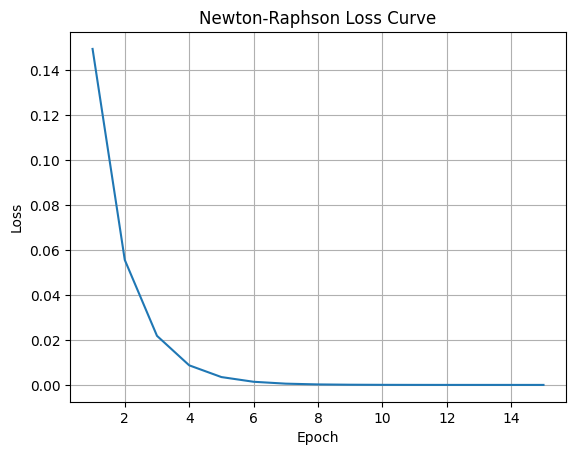

In [43]:
Model = LogisticRegression()
Model.trainNR(x_train, y_train, epoch=15)